In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Holy search for Determinism

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 7

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
#tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# 6. Keras
tf.keras.utils.set_random_seed(seed_value)
tf.config.experimental.enable_op_determinism()

In [3]:
import tensorflow as tf
from tensorflow import keras

# Tests GPU local

In [4]:
print("GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs: 0


In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
print(tf.version.VERSION)

2.8.0


In [7]:
import sys
sys.version

'3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]'

# TP

In [8]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path
import math

# lib para trabajar con arrays
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt
import seaborn as sns

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import layers

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [9]:
from tensorflow.keras.datasets import fashion_mnist
'''
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
(X_train, Y_train) = train 
(X_test, Y_test) = test
'''
train, test = fashion_mnist.load_data()
X_train, Y_train = train 
X_test, Y_test = test

In [10]:
# CONSTANTES

LABELS = np.unique(Y_train).tolist()
LABELS_TEXT = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
INPUTS = 28*28
OUTPUTS = len(LABELS)

# EDA

El dataset se divide en un set de train con 60.000 ejemplos, y un set de test con otros 10.000. Cada ejemplo consta de una imagen en escala de grises de 28x28 pixeles (784 en total), asociado a una etiqueta de 10 clases.
Cada pixel es representado por un solo valor, indicando el nivel de brillo u obscuridad en él. Estos valores van entre 0 y 255.

### Etiquetas
- 0 - T-shirt/top
- 1 - Trouser
- 2 - Pullover
- 3 - Dress
- 4 - Coat
- 5 - Sandal
- 6 - Shirt
- 7 - Sneaker
- 8 - Bag
- 9 - Ankle boot

Las dimensiones de las imágenes pueden apreciarse al hacer un `.shape` de los datasets:

In [11]:
print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (60000, 28, 28)
Test: (10000, 28, 28)


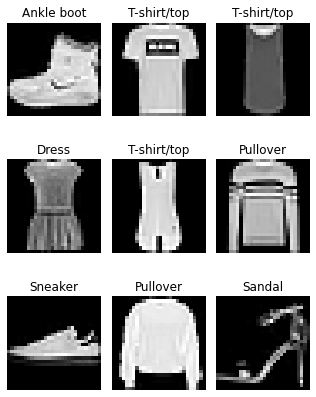

In [12]:
def sample_images(dataset): 
    # specify the number of rows and columns you want to see
    num_row = 3
    num_col = 3

    # get a segment of the dataset
    num = num_row*num_col
    if dataset == train:
        images, labels = X_train[:num], Y_train[:num]
    elif dataset == test:   # Test dataset
        images, labels = X_test[:num], Y_test[:num]
    else:                   # Train with data augmentation dataset
        images, labels = X_train_da[:num], Y_train_da[:num]

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        #plt.title(labels[i])
        plt.title(LABELS_TEXT[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

sample_images(train)

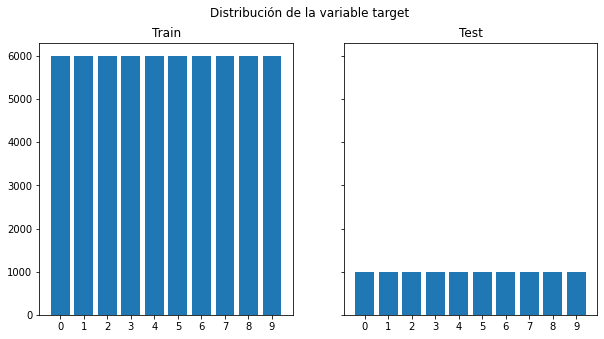

In [13]:
df_ytrain = pd.DataFrame(data=Y_train)
df_ytest = pd.DataFrame(data=Y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
fig.suptitle('Distribución de la variable target')
ax1.bar([0,1,2,3,4,5,6,7,8,9],df_ytrain.value_counts())
ax2.bar([0,1,2,3,4,5,6,7,8,9],df_ytest.value_counts())
ax1.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax1.title.set_text('Train')
ax2.title.set_text('Test')

La variable a predecir tiene una **distribución uniforme** en todo ambos datasets.

In [14]:
# Escalado de valores a un rango 0-1

#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)


Activation functions
    https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

Loss functions
    https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

Neurons and layers
    https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

https://www.hindawi.com/journals/mpe/2013/425740/
https://peerj.com/articles/cs-724/

    The number of hidden neurons should be between the size of the input layer and the size of the output layer.
    The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
    The number of hidden neurons should be less than twice the size of the input layer.


> In modern neural networks, the default recommendation is to use the rectified linear unit or ReLU …

— Page 174, Deep Learning, 2016.

# Funciones

In [15]:
EPOCHS = 50
BATCH_SIZE = 256
VERBOSE = 0

import matplotlib.ticker as ticker

# Fit model
def fit_model(model, x=X_train, y=Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, plot_model=True, verbose=VERBOSE, compare=False):
    history = model.fit(
        x,
        y,
        epochs = epochs,
        batch_size = batch_size,
        validation_data=(X_test, Y_test),
        verbose=verbose,
    )

    if verbose == 0:
        print('Trained the model for', epochs, 'epochs')

        final_train_accuracy = model.history.history['accuracy'][-1]
        final_validation_accuracy = model.history.history['val_accuracy'][-1]
        final_train_loss = model.history.history['loss'][-1]
        final_validation_loss = model.history.history['val_loss'][-1]

        if compare:
            initial_train_accuracy = model.history.history['accuracy'][0]
            initial_validation_accuracy = model.history.history['val_accuracy'][0]
            initial_train_loss = model.history.history['loss'][0]
            initial_validation_loss = model.history.history['val_loss'][0]

            middle_value = math.floor(len(model.history.history['accuracy'])/2)

            middle_train_accuracy = model.history.history['accuracy'][middle_value]
            middle_validation_accuracy = model.history.history['val_accuracy'][middle_value]
            middle_train_loss = model.history.history['loss'][middle_value]
            middle_validation_loss = model.history.history['val_loss'][middle_value]

            print('- Train: \t Initial Accuracy:', format(round(initial_train_accuracy, 3), '.3f'), 
                '   Middle Accuracy:', format(round(middle_train_accuracy, 3), '.3f'), 
                '   Final Accuracy:', format(round(final_train_accuracy, 3), '.3f'), '   |',
                '   Initial Loss:', format(round(initial_train_loss, 3), '.3f'), 
                '   Middle Loss:', format(round(middle_train_loss, 3), '.3f'), 
                '   Final Loss:', format(round(final_train_loss, 3), '.3f'))
            print('- Validation: \t Initial Accuracy:', format(round(initial_validation_accuracy, 3), '.3f'), 
                '   Middle Accuracy:', format(round(middle_validation_accuracy, 3), '.3f'),
                '   Final Accuracy:', format(round(final_validation_accuracy, 3), '.3f'), '   |',
                '   Initial Loss:', format(round(initial_validation_loss, 3), '.3f'), 
                '   Middle Loss:', format(round(middle_validation_loss, 3), '.3f'),
                '   Final Loss:', format(round(final_validation_loss, 3), '.3f'))    
        else:
            print('- Train: \t Accuracy:', format(round(final_train_accuracy, 3), '.3f'), '\t Loss:', format(round(final_train_loss, 3), '.3f'))
            print('- Validation: \t Accuracy:', format(round(final_validation_accuracy, 3), '.3f'), '\t Loss:', format(round(final_validation_loss, 3), '.3f'))

    return history

# Plot train and validation accuracy and/or loss of up to three models

# Parameter loss works in two ways:
#   - If only one model present, the function plots Accuracy and Loss next to eachother on two subplots
#   - If more than one model present, the function plots Accuracy (if loss=False) or Loss (if loss=True) of all models present
def plot_model(model_1, model_2=None, model_3=None, loss=False, title='', subtitle_1='', subtitle_2='', subtitle_3='', epochs=EPOCHS):
    if loss:
        ylabel = 'Loss'
        train_metric = 'loss'
        validation_metric = 'val_loss'
    else:
        ylabel = 'Accuracy'
        train_metric = 'accuracy'
        validation_metric = 'val_accuracy'

    axes_list = []

    if model_2 is None and model_3 is None:
        if not loss:
            plt.figure(figsize=(7, 5)) 
            plt.title(title)
            plt.plot(model_1.history[train_metric], label='train')
            plt.plot(model_1.history[validation_metric], label='validation')
            if epochs <= 20:
                plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
            else:
                original_ticks_list = np.arange(epochs)
                # Just 3 ticks (min, half, max)
                new_ticks_list = [min(original_ticks_list), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)]
                new_ticks_label_list = [min(original_ticks_list+1), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)+1]
                plt.xticks(new_ticks_list, new_ticks_label_list)
                
            plt.ylabel(ylabel)
            plt.xlabel('Epoch')
            plt.legend(loc='best')
            plt.grid()
            plt.show()
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15.3, 5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax1.plot(model_1.history['accuracy'], label='train')
            ax2.plot(model_1.history['loss'], label='train')
            ax1.plot(model_1.history['val_accuracy'], label='validation')
            ax2.plot(model_1.history['val_loss'], label='validation')

            axes_list = [ax1, ax2]
        
    else:
        if model_3 is None:
            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15.3, 5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax1.plot(model_1.history[train_metric], label='train')
            ax2.plot(model_2.history[train_metric], label='train')
            ax1.plot(model_1.history[validation_metric], label='validation')
            ax2.plot(model_2.history[validation_metric], label='validation')

            axes_list = [ax1, ax2]

        else:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(24, 5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax3.title.set_text(subtitle_3)
            ax1.plot(model_1.history[train_metric], label='train')
            ax2.plot(model_2.history[train_metric], label='train')
            ax3.plot(model_3.history[train_metric], label='train')
            ax1.plot(model_1.history[validation_metric], label='validation')
            ax2.plot(model_2.history[validation_metric], label='validation')
            ax3.plot(model_3.history[validation_metric], label='validation')

            ax2.tick_params(
            axis='y',
            which='both',   
            left=False
            )  

            axes_list = [ax1, ax2, ax3]

    for ax in axes_list:
        if epochs <= 20:
            ax.set_xticks(np.arange(epochs), np.arange(1, epochs+1))
        else:
            original_ticks_list = np.arange(epochs)
            # Just 3 ticks (min, half, max)
            new_ticks_list = [min(original_ticks_list), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)]
            new_ticks_label_list = [min(original_ticks_list+1), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)+1]
            ax.set_xticks(new_ticks_list, new_ticks_label_list)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend(loc='best')
        ax.grid()

        ax.tick_params(
            axis='y',
            which='both',   
            right=False,
            labelright=False,
            left=True,
            labelleft=True,
        )

# Plot train and validation accuracy of up to three models
def plot_cm(model_1, model_2=None, model_3=None, dataset=train, title='', subtitle_1='', subtitle_2='', subtitle_3=''):
    X_train, Y_train = dataset
    labels = Y_train #Rename just for the sake of understanding

    if model_2 is None and model_3 is None:
        predictions = np.argmax(model_1.predict(X_train), axis=-1)
        
        print(' - Accuracy:', accuracy_score(labels, predictions))

        fig, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(confusion_matrix(labels, predictions), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT)

        plt.title(title)
        plt.xlabel('Predicted class') 
        plt.ylabel('True class') 
        
    else:
        if model_3 is None:
            predictions_model_1 = np.argmax(model_1.predict(X_train), axis=-1)
            predictions_model_2 = np.argmax(model_2.predict(X_train), axis=-1)

            print(' -', subtitle_1,'Accuracy:', accuracy_score(labels, predictions_model_1))
            print(' -', subtitle_2,'Accuracy:', accuracy_score(labels, predictions_model_2))

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15.3,5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            axes_list = [ax1, ax2]
            g1 = sns.heatmap(confusion_matrix(labels, predictions_model_1), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax1)
            g2 = sns.heatmap(confusion_matrix(labels, predictions_model_2), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax2)

        else:
            predictions_model_1 = np.argmax(model_1.predict(X_train), axis=-1)
            predictions_model_2 = np.argmax(model_2.predict(X_train), axis=-1)
            predictions_model_3 = np.argmax(model_3.predict(X_train), axis=-1)

            print(' -', subtitle_1,'Accuracy:', accuracy_score(labels, predictions_model_1))
            print(' -', subtitle_2,'Accuracy:', accuracy_score(labels, predictions_model_2))
            print(' -', subtitle_3,'Accuracy:', accuracy_score(labels, predictions_model_3))

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax3.title.set_text(subtitle_3)
            axes_list = [ax1, ax2, ax3]
            g1 = sns.heatmap(confusion_matrix(labels, predictions_model_1), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax1)
            g2 = sns.heatmap(confusion_matrix(labels, predictions_model_2), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax2)
            g3 = sns.heatmap(confusion_matrix(labels, predictions_model_3), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax3)

        for ax in axes_list:
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

    plt.tight_layout()
    plt.show()

# MLP Experimentation

Para experimentar con diversos aspectos de redes neuronales MLP vamos a buscar variar no solo su arquitectura -en términos de cantidad de capas ocultas y neuronas- sino también con la cantidad de Epochs, tamaño del Batch Size y learning rate utilizados.

Primero comenzamos planteando modelos muy pequeños, de entre 1 y 3 capas ocultas respectivamente, y con entre 1 y 2 neuronas cada una de ellas. El objetivo de esto es observar el comportamiento de una red neuronal cuando ya no tiene capacidad de seguir aprendiendo. Las observaciones resultantes pueden ayudarnos a comprender de mejor manera el comportamiento de modelos más complejos más adelante.

## One-perceptron layers

Tomando como base el hecho de que queremos mapear nuestros inputs en un espacio de tan solo una dimensión (un array con 10 elementos), en teoría el problema podría ser resuelto por solo una neurona. Por eso mismo las primeras pruebas son modelos con una, dos y tres capas ocultas, cada una con solo una neurona de tipo perceptrón dentro.

In [16]:
mlp_1l_1_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_1l_1_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_1l_1_relu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1)                 785       
                                                                 
 dense_1 (Dense)             (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_2l_1_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation='relu'),
    Dense(1, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_1_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_1_relu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 785       
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
 dense_4 (Dense)             (None, 10)                20        
                                                                 
Total params: 807
Trainable params: 807
Non-trainable params: 0
_________________________________________________________________


In [18]:
mlp_3l_1_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation='relu'),
    Dense(1, activation='relu'),
    Dense(1, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_1_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_1_relu.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 785       
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
 dense_8 (Dense)             (None, 10)                20        
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [19]:
print('mlp_1l_1_relu')
mlp_1l_1_relu_b256 = fit_model(mlp_1l_1_relu, batch_size=256, epochs=200, compare=True)
print('mlp_2l_1_relu')
mlp_2l_1_relu_b256 = fit_model(mlp_2l_1_relu, batch_size=256, epochs=200, compare=True)
print('mlp_3l_1_relu')
mlp_3l_1_relu_b256 = fit_model(mlp_3l_1_relu, batch_size=256, epochs=200, compare=True)

mlp_1l_1_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.200    Middle Accuracy: 0.492    Final Accuracy: 0.540    |    Initial Loss: 2.059    Middle Loss: 1.209    Final Loss: 1.159
- Validation: 	 Initial Accuracy: 0.219    Middle Accuracy: 0.485    Final Accuracy: 0.543    |    Initial Loss: 1.961    Middle Loss: 1.227    Final Loss: 1.185
mlp_2l_1_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.098    Middle Accuracy: 0.098    Final Accuracy: 0.099    |    Initial Loss: 2.303    Middle Loss: 2.303    Final Loss: 2.303
- Validation: 	 Initial Accuracy: 0.100    Middle Accuracy: 0.100    Final Accuracy: 0.100    |    Initial Loss: 2.303    Middle Loss: 2.303    Final Loss: 2.303
mlp_3l_1_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.098    Middle Accuracy: 0.098    Final Accuracy: 0.099    |    Initial Loss: 2.303    Middle Loss: 2.303    Final Loss: 2.303
- Validation: 	 Initial Accuracy: 0.100    Middle Accuracy: 0.10

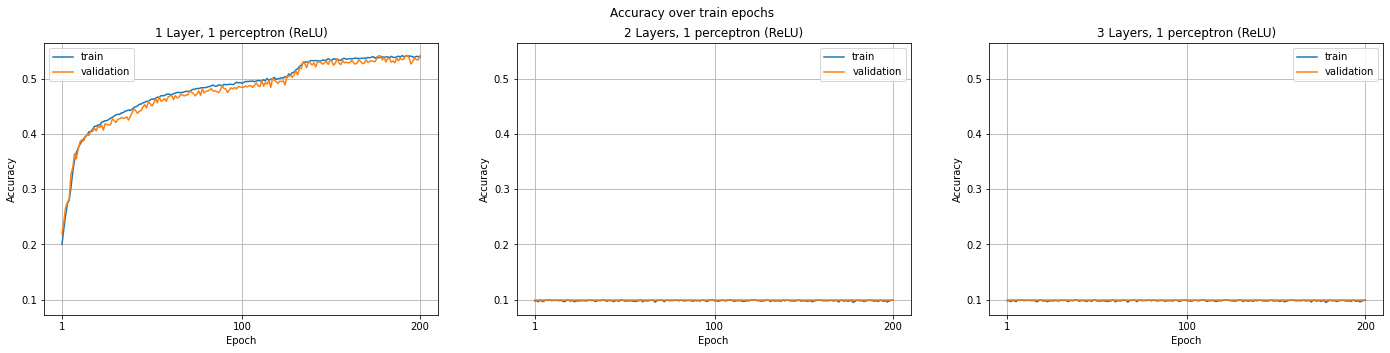

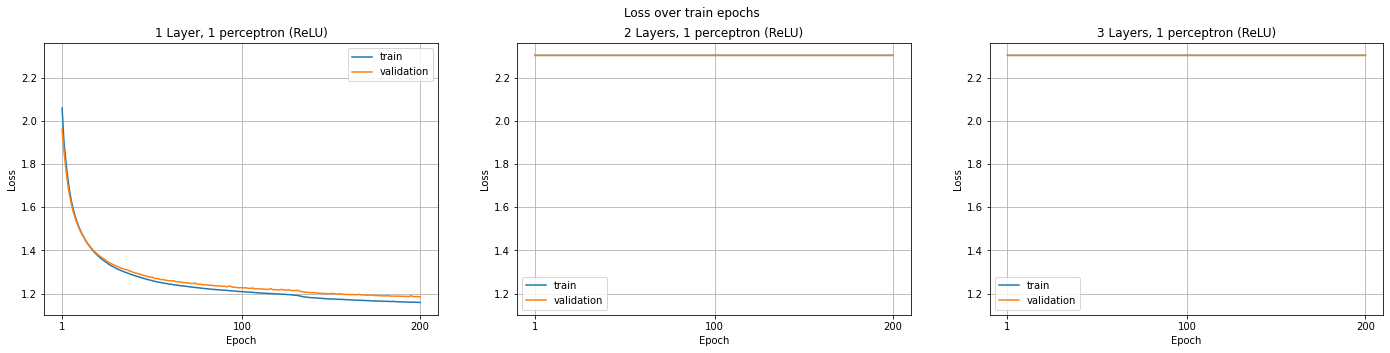

In [20]:
plot_model(model_1=mlp_1l_1_relu_b256, model_2=mlp_2l_1_relu_b256, model_3=mlp_3l_1_relu_b256, epochs=200,
    title='Accuracy over train epochs', subtitle_1='1 Layer, 1 perceptron (ReLU)', subtitle_2='2 Layers, 1 perceptron (ReLU)', subtitle_3='3 Layers, 1 perceptron (ReLU)')
plot_model(model_1=mlp_1l_1_relu_b256, model_2=mlp_2l_1_relu_b256, model_3=mlp_3l_1_relu_b256, epochs=200, loss=True,
    title='Loss over train epochs', subtitle_1='1 Layer, 1 perceptron (ReLU)', subtitle_2='2 Layers, 1 perceptron (ReLU)', subtitle_3='3 Layers, 1 perceptron (ReLU)')

El primer modelo alcanza un Accuracy de 0.55 luego de casi 200 epochs, lo cual uno podría interpretar como interesante considerando que solo utilizamos una capa oculta con una sola neurona. Sin embargo, algo para tener en cuenta es el Loss elevado, que ronda el 1.0.

Mientras tanto, los modelos 2 y 3 quedan estancados con Accuracy en 0.1 y Loss en 2.3. Una de las hipótesis sobre la causa de esto es 'Dying ReLU problem'. Debido a este caso en particular, a continuación planteamos los mismos modelos (2 y 3 capas ocultas con 1 neurona cada una) pero utilizando la función de activación Leaky ReLU, la cual algunas veces permite subsanar dicho problema.

## Leaky ReLU

In [16]:
mlp_2l_1_leakyrelu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_1_leakyrelu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_1_leakyrelu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1)                 785       
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
 dense_2 (Dense)             (None, 10)                20        
                                                                 
Total params: 807
Trainable params: 807
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_3l_1_leakyrelu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_1_leakyrelu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_1_leakyrelu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 785       
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
 dense_6 (Dense)             (None, 10)                20        
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [18]:
print('mlp_2l_1_leakyrelu')
mlp_2l_1_leakyrelu_b256 = fit_model(mlp_2l_1_leakyrelu, batch_size=256, epochs=200, compare=True)
print('mlp_3l_1_leakyrelu')
mlp_3l_1_leakyrelu_b256 = fit_model(mlp_3l_1_leakyrelu, batch_size=256, epochs=200, compare=True)

mlp_2l_1_leakyrelu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.183    Middle Accuracy: 0.527    Final Accuracy: 0.531    |    Initial Loss: 2.050    Middle Loss: 1.100    Final Loss: 1.097
- Validation: 	 Initial Accuracy: 0.198    Middle Accuracy: 0.525    Final Accuracy: 0.540    |    Initial Loss: 1.909    Middle Loss: 1.119    Final Loss: 1.118
mlp_3l_1_leakyrelu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.167    Middle Accuracy: 0.511    Final Accuracy: 0.507    |    Initial Loss: 2.078    Middle Loss: 1.292    Final Loss: 1.288
- Validation: 	 Initial Accuracy: 0.192    Middle Accuracy: 0.511    Final Accuracy: 0.510    |    Initial Loss: 1.929    Middle Loss: 1.326    Final Loss: 1.324


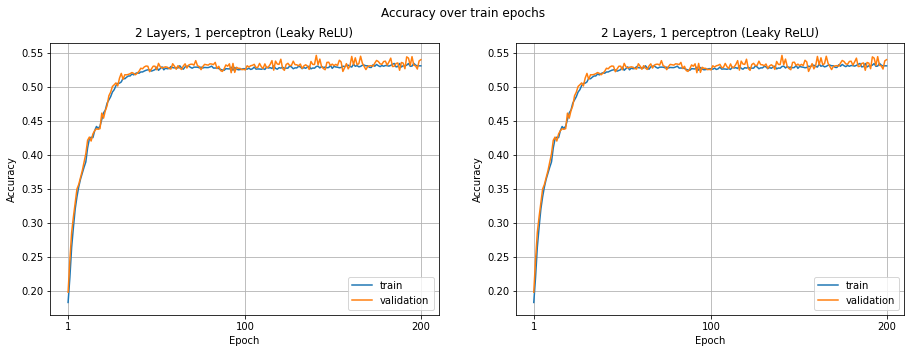

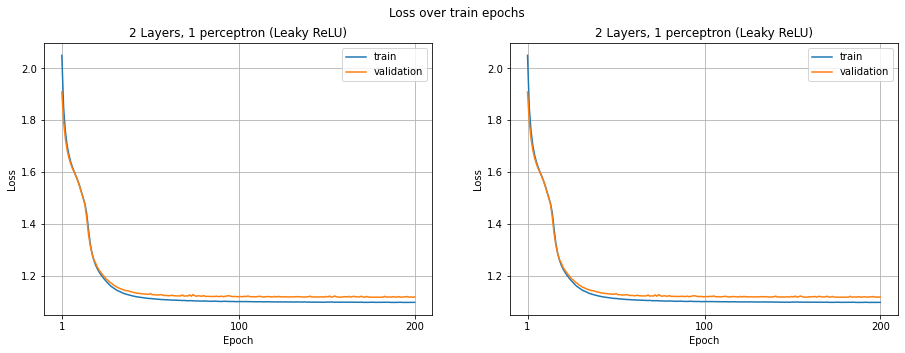

In [19]:
plot_model(model_1=mlp_2l_1_leakyrelu_b256, model_2=mlp_2l_1_leakyrelu_b256, epochs=200,
    title='Accuracy over train epochs', subtitle_1='2 Layers, 1 perceptron (Leaky ReLU)', subtitle_2='2 Layers, 1 perceptron (Leaky ReLU)')
plot_model(model_1=mlp_2l_1_leakyrelu_b256, model_2=mlp_2l_1_leakyrelu_b256, epochs=200, loss=True,
    title='Loss over train epochs', subtitle_1='2 Layers, 1 perceptron (Leaky ReLU)', subtitle_2='2 Layers, 1 perceptron (Leaky ReLU)')

El uso de Leaky ReLU en los modelos 2 y 3 evita el estancamiento visto en las ejecuciones anteriores. Respecto a su rendimiento, estos modelos llegan a un Accuracy similar al modelo 1 anterior (1 layer, 1 perceptron (ReLU)) en muchas menos epochs, y con un Loss un tanto menor, aunque todavía elevado en términos generales.

## Two-perceptron Layers

In [16]:
mlp_1l_2_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_1l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_1l_2_relu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_2l_2_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_2_relu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1570      
                                                                 
 dense_3 (Dense)             (None, 2)                 6         
                                                                 
 dense_4 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
_________________________________________________________________


In [18]:
mlp_3l_2_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_2_relu.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 1570      
                                                                 
 dense_6 (Dense)             (None, 2)                 6         
                                                                 
 dense_7 (Dense)             (None, 2)                 6         
                                                                 
 dense_8 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [19]:
print('mlp_1l_2_relu')
mlp_1l_2_relu_b256 = fit_model(mlp_1l_2_relu, batch_size=256, epochs=200, compare=True)
print('mlp_2l_2_relu')
mlp_2l_2_relu_b256 = fit_model(mlp_2l_2_relu, batch_size=256, epochs=200, compare=True)
print('mlp_3l_2_relu')
mlp_3l_2_relu_b256 = fit_model(mlp_3l_2_relu, batch_size=256, epochs=200, compare=True)

mlp_1l_2_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.287    Middle Accuracy: 0.726    Final Accuracy: 0.737    |    Initial Loss: 1.840    Middle Loss: 0.779    Final Loss: 0.758
- Validation: 	 Initial Accuracy: 0.386    Middle Accuracy: 0.718    Final Accuracy: 0.725    |    Initial Loss: 1.595    Middle Loss: 0.818    Final Loss: 0.803
mlp_2l_2_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.098    Middle Accuracy: 0.098    Final Accuracy: 0.099    |    Initial Loss: 2.303    Middle Loss: 2.303    Final Loss: 2.303
- Validation: 	 Initial Accuracy: 0.100    Middle Accuracy: 0.100    Final Accuracy: 0.100    |    Initial Loss: 2.303    Middle Loss: 2.303    Final Loss: 2.303
mlp_3l_2_relu
Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.191    Middle Accuracy: 0.693    Final Accuracy: 0.713    |    Initial Loss: 2.070    Middle Loss: 0.841    Final Loss: 0.813
- Validation: 	 Initial Accuracy: 0.197    Middle Accuracy: 0.68

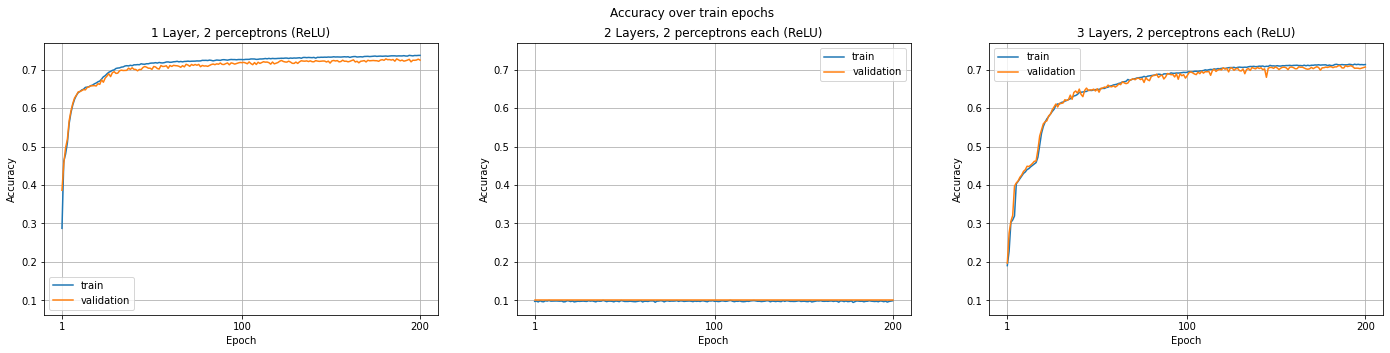

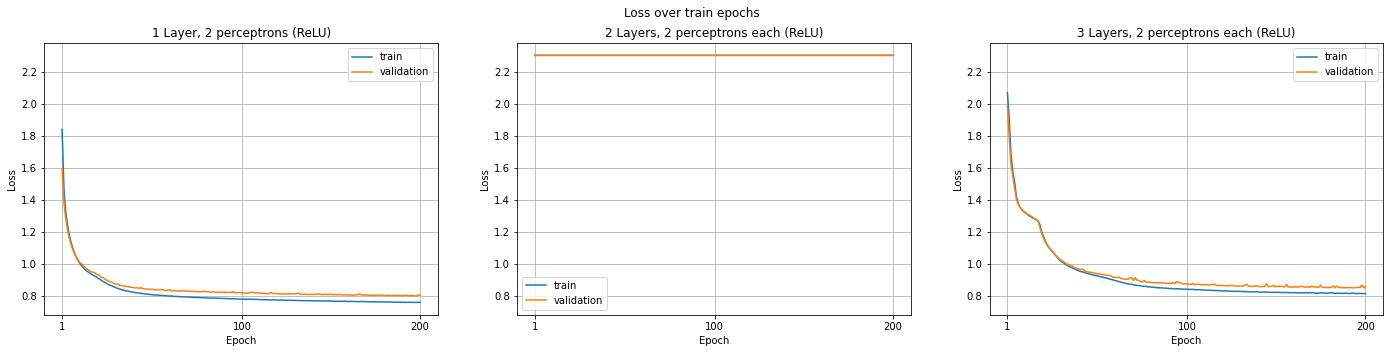

In [20]:
plot_model(model_1=mlp_1l_2_relu_b256, model_2=mlp_2l_2_relu_b256, model_3=mlp_3l_2_relu_b256, epochs=200,
    title='Accuracy over train epochs', subtitle_1='1 Layer, 2 perceptrons (ReLU)', subtitle_2='2 Layers, 2 perceptrons each (ReLU)', subtitle_3='3 Layers, 2 perceptrons each (ReLU)')
plot_model(model_1=mlp_1l_2_relu_b256, model_2=mlp_2l_2_relu_b256, model_3=mlp_3l_2_relu_b256, epochs=200, loss=True,
    title='Loss over train epochs', subtitle_1='1 Layer, 2 perceptrons (ReLU)', subtitle_2='2 Layers, 2 perceptrons each (ReLU)', subtitle_3='3 Layers, 2 perceptrons each (ReLU)')

Podemos observar que en el primer y tercer modelo el Accuracy tiene una asíntota alrededor de 0.70-0.75. Cabe destacar que el tercero tarda muchos más epochs en llegar al mismo nivel.
Por su parte, tanto el Accuracy como el Loss del segundo modelo quedan estancados en 0.1 y 2.3 respectivamente por la totalidad del entrenamiento. De nuevo, una de las hipótesis sobre la causa de esto es 'Dying ReLU problem' mencionado antes. Debido a esto, a continuación planteamos el mismo modelo (2 capas ocultas con 2 neuronas cada una) utilizando la función de activación Leaky ReLU.

## Leaky ReLU

In [16]:
mlp_2l_2_leakyrelu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_2_leakyrelu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_2_leakyrelu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_2l_2_leakyrelu_b256 = fit_model(mlp_2l_2_leakyrelu, batch_size=256, epochs=200, compare=True)

Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.260    Middle Accuracy: 0.736    Final Accuracy: 0.754    |    Initial Loss: 1.954    Middle Loss: 0.738    Final Loss: 0.682
- Validation: 	 Initial Accuracy: 0.333    Middle Accuracy: 0.722    Final Accuracy: 0.738    |    Initial Loss: 1.757    Middle Loss: 0.784    Final Loss: 0.752


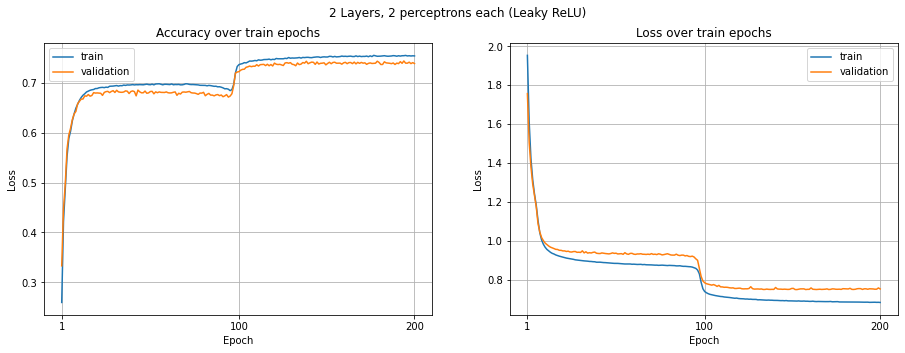

In [18]:
plot_model(model_1=mlp_2l_2_leakyrelu_b256, epochs=200, loss=True,
    title='2 Layers, 2 perceptrons each (Leaky ReLU)', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

El rendimiento de este modelo que utiliza Leaky ReLU como función de activación arroja valores finales similares a la tanda anterior que utilizaba ReLU, pero, al igual que el último de la misma, requiere de muchos epochs de entrenamiento adicionales para llegar al mismo punto del primer ejemplo. Algo a destacar es un Loss un tanto menor que todos los ejemplos anteriores.

Sea cual sea el caso, llega un punto donde ninguno puede seguir aprendiendo (cerca de Accuracy = 0.75), lo cual demanda que planteemos redes más profundas. Esto les dará la posibilidad de reconocer detalles o aspectos más abstractos. La cantidad de neuronas también será variada ligeramente, buscando mejor Accuracy, menor Loss y tratando de evitar el overfitting.

## Batch Size

Planteamos un modelo MLP de prueba y lo entrenamos con tres `batch_size` diferentes (64, 256 y 1024) para así analizar el comportamiento del mismo.

In [16]:
mlp_batch_test = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(5, activation='relu'),
    Dense(5, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_batch_test.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_batch_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 5)                 3925      
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
 dense_3 (Dense)             (None, 10)                30        
                                                                 
Total params: 3,997
Trainable params: 3,997
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_batch_test_b64 = fit_model(mlp_batch_test, batch_size=64, epochs=200, compare=True)

Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.397    Middle Accuracy: 0.801    Final Accuracy: 0.806    |    Initial Loss: 1.552    Middle Loss: 0.570    Final Loss: 0.551
- Validation: 	 Initial Accuracy: 0.564    Middle Accuracy: 0.772    Final Accuracy: 0.779    |    Initial Loss: 1.204    Middle Loss: 0.716    Final Loss: 0.753


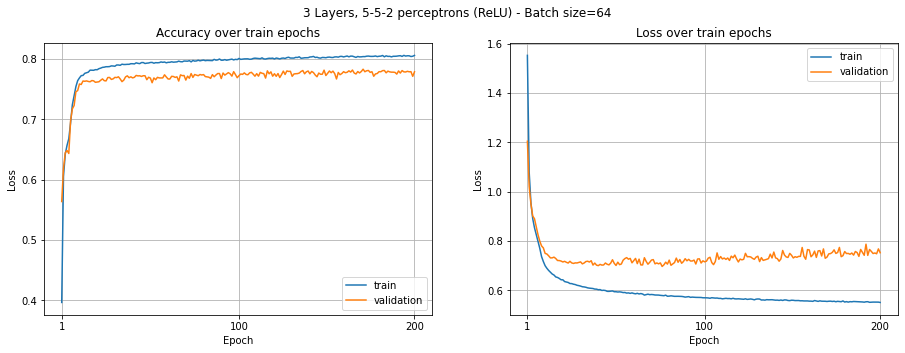

In [18]:
plot_model(mlp_batch_test_b64, epochs=200, loss=True,
    title='3 Layers, 5-5-2 perceptrons (ReLU) - Batch size=64', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

El gráfico de Loss indica cómo en las cercanías del Epoch nro. 25 los errores de Validation comienzan a ir en alza, mientras que los errores de Train continúan a la baja. Esto indica un overfitting, por lo que una de las alternativas sería cortar el entrenamiento en ese punto.

In [17]:
mlp_batch_test_b256 = fit_model(mlp_batch_test, batch_size=256, epochs=200, compare=True)

Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.166    Middle Accuracy: 0.751    Final Accuracy: 0.775    |    Initial Loss: 2.068    Middle Loss: 0.706    Final Loss: 0.635
- Validation: 	 Initial Accuracy: 0.203    Middle Accuracy: 0.740    Final Accuracy: 0.756    |    Initial Loss: 1.886    Middle Loss: 0.779    Final Loss: 0.738


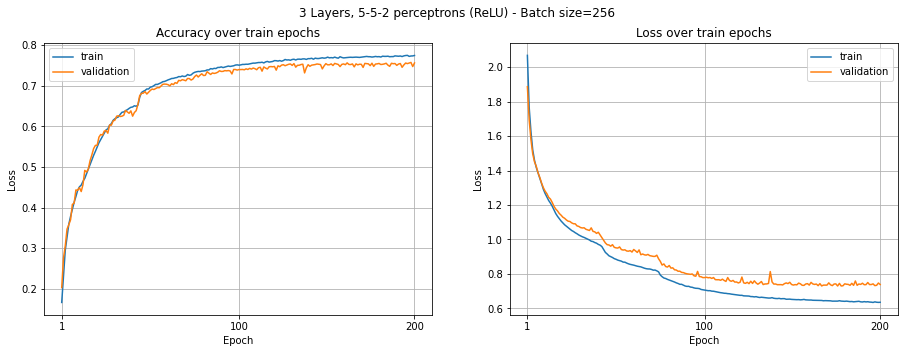

In [18]:
plot_model(mlp_batch_test_b256, epochs=200, loss=True,
    title='3 Layers, 5-5-2 perceptrons (ReLU) - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_batch_test_b1024 = fit_model(mlp_batch_test, batch_size=1024, epochs=200, compare=True)

Trained the model for 200 epochs
- Train: 	 Initial Accuracy: 0.143    Middle Accuracy: 0.750    Final Accuracy: 0.758    |    Initial Loss: 2.198    Middle Loss: 0.725    Final Loss: 0.690
- Validation: 	 Initial Accuracy: 0.169    Middle Accuracy: 0.738    Final Accuracy: 0.740    |    Initial Loss: 2.137    Middle Loss: 0.812    Final Loss: 0.797


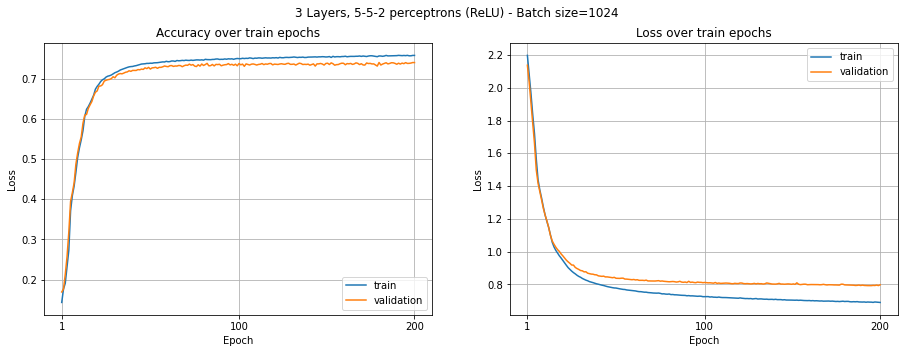

In [18]:
plot_model(mlp_batch_test_b1024, epochs=200, loss=True,
    title='3 Layers, 5-5-2 perceptrons (ReLU) - Batch size=1024', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

Comparación del tiempo de entrenamiento requerido por el mismo modelo entrenado con diferentes `batch_size`:

| batch_size | Tiempo (s)  |
| ---------- | ----------- |
| 64         | 200         |
| 256        | 82          |
| 1024       | 61          |

- Un mayor `batch_size` conlleva un entrenamiento más rápido, ya que los pesos internos del modelo se actualizan con menor frecuencia. 
- El Accuracy disminuye a medida que aumenta el `batch_size`; consecuencia directa de que los pesos se actualicen menos seguido.
- El Loss de Validation continúa aumentando respecto al de Train a medida que pasan los `epochs`. Esto es otro indicativo de overfitting.

Estas observaciones nos indican que el modelo actual, con tres capas ocultas de 100 neuronas cada una, es tiene suficiente capacidad como para memorizar los datos de Train. En este caso tenemos varias alternativas:
1. Añadir capas de dropout.
2. Reducir la cantidad de capas y/o neuronas.
3. Añadir más datos.

Procedemos a testear la primer situación, utilizando capas de Dropout entre las capas ocultas de la red.

### Test con Dropout

In [ ]:
mlp_3l_100_d02 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100_d02.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100_d02.summary()

In [ ]:
mlp_3l_100_d02_b64 = fit_model(mlp_3l_100_d02, batch_size=64)

In [ ]:
mlp_3l_100_d02_b256 = fit_model(mlp_3l_100_d02, batch_size=256)

In [ ]:
mlp_3l_100_d02_b1024 = fit_model(mlp_3l_100_d02, batch_size=1024)

In [ ]:
plot_model(model_1=mlp_3l_100_d02_b64, model_2=mlp_3l_100_d02_b256, model_3=mlp_3l_100_d02_b1024, 
    title='Loss over train epochs', subtitle_1='Batch Size=64, Dropout=0.2', subtitle_2='Batch Size=256, Dropout=0.2', subtitle_3='Batch Size=1024, Dropout=0.2')

In [ ]:
plot_model(model_1=mlp_3l_100_d02_b64, model_2=mlp_3l_100_d02_b256, model_3=mlp_3l_100_d02_b1024, loss=True, 
    title='Loss over train epochs', subtitle_1='Batch Size=64, Dropout=0.2', subtitle_2='Batch Size=256, Dropout=0.2', subtitle_3='Batch Size=1024, Dropout=0.2')

La adición de tres capas de Dropout controló el crecimiento del loss de Validation y añadió ciertas irregularidades en las métricas, al menos comparándolo con los gráficos más 'suaves' obtenidos en el ejemplo anterior.
Esto es entendible debido a la naturaleza de cómo opera Dropout, al asignar valores 0 en los inputs de manera random con determinada frecuencia. Además, también subió levemente el piso del loss en Train.

| batch_size | Tiempo (s)  |
| ---------- | ----------- |
| 64         | 72          |
| 256        | 40          |
| 1024       | 33          |

### Test con menor cantidad de neuronas

In [ ]:
mlp_3l_10 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_10.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_10.summary()

In [ ]:
mlp_3l_10_b64 = fit_model(mlp_3l_10, batch_size=64)


In [ ]:
mlp_3l_10_b256 = fit_model(mlp_3l_10, batch_size=256)

In [ ]:
mlp_3l_10_b1024 = fit_model(mlp_3l_10, batch_size=1024)

In [ ]:
plot_model(model_1=mlp_3l_10_b64, model_2=mlp_3l_10_b256, model_3=mlp_3l_10_b1024,
    title='Accuracy over train epochs', subtitle_1='Batch Size=64', subtitle_2='Batch Size=256', subtitle_3='Batch Size=1024')

In [ ]:
plot_model(model_1=mlp_3l_10_b64, model_2=mlp_3l_10_b256, model_3=mlp_3l_10_b1024, loss=True, 
    title='Loss over train epochs', subtitle_1='Batch Size=64', subtitle_2='Batch Size=256', subtitle_3='Batch Size=1024')

Al reducir la cantidad de neuronas en un 90% (de 100 a 10) pero manteniendo las tres capas densas iniciales alcanzamos valores muy similares independientemente del `batch_size`. De todas maneras, en el 2do y 3er ejemplo el loss de Validation sigue incrementándose mientras el de Train se mantiene estable, lo cual indica un overfitting.

A partir de este momento tomamos como base al segundo modelo (con `batch_size = 256`) para continuar con la experimentación.

El hecho de que el loss no cambie a lo largo de los `epochs` es llamativo. Esto ocurrió cuando redujimos la cantidad de neuronas, por lo que podríamos suponer que la red ya no tiene capacidad de aprender. 
Procedemos a realizar dos cambios:
1. Disminuir el 

In [ ]:
mlp_3l_10_lr00001 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_10_lr00001.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001, #Default 0.001
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_10_lr00001.summary()

In [ ]:
mlp_3l_10_lr00001_b256 = fit_model(mlp_3l_10_lr00001, batch_size=256)

In [ ]:
mlp_4l_10 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_4l_10.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_4l_10.summary()

In [ ]:
mlp_4l_10_b256 = fit_model(mlp_4l_10, batch_size=256)

In [ ]:
plot_model(model_1=mlp_3l_10_lr00001_b256, model_2=mlp_3l_10_b256, model_3=mlp_4l_10_b256,
    title='Loss over train epochs', subtitle_1='Batch Size=256, Learning Rate=0.0001')

In [ ]:
plot_model(model_1=mlp_3l_10_lr00001_b256, model_2=mlp_3l_10_b256, model_3=mlp_4l_10_b256, loss=True, 
    title='Loss over train epochs', subtitle_1='Batch Size=256')

## Learning Rate

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [ ]:
mlp_3l_100_lr0001 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100_lr0001.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001, #Default
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100_lr0001.summary()

In [ ]:
mlp_3l_100_lr0001_fit = fit_model(mlp_3l_100_lr0001)

In [ ]:
mlp_3l_100_lr001 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100_lr001.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100_lr001.summary()

In [ ]:
mlp_3l_100_lr001_fit = fit_model(mlp_3l_100_lr001)

In [ ]:
mlp_3l_100_lr01 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_100_lr01.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.1,
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_100_lr01.summary()

In [ ]:
mlp_3l_100_lr01_fit = fit_model(mlp_3l_100_lr01)

In [ ]:
plot_model(model_1=mlp_3l_100_lr0001_fit, model_2=mlp_3l_100_lr001_fit, model_3=mlp_3l_100_lr01_fit, 
    title='Accuracy over train epochs with different learning rates', subtitle_1='Learning Rate=0.001', subtitle_2='Learning Rate=0.01', subtitle_3='Learning Rate=0.1')

In [ ]:
plot_model(model_1=mlp_3l_100_lr0001_fit, model_2=mlp_3l_100_lr001_fit, model_3=mlp_3l_100_lr01_fit, loss=True,
    title='Accuracy over train epochs with different learning rates', subtitle_1='Learning Rate=0.001', subtitle_2='Learning Rate=0.01', subtitle_3='Learning Rate=0.1')

Puede apreciarse que al utilizar un learning rate 10 veces más grande al default (0.01, en lugar de 0.001)

## Amount of neurons

In [ ]:
mlp_3l_10 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_10.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_10.summary()

In [ ]:
mlp_3l_20 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_20.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_20.summary()

In [ ]:
mlp_3l_40 = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(40, activation='relu'),
    Dense(40, activation='relu'),
    Dense(40, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_40.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_40.summary()

In [ ]:
mlp_3l_10_fit = fit_model(mlp_3l_10)
mlp_3l_20_fit = fit_model(mlp_3l_20)
mlp_3l_40_fit = fit_model(mlp_3l_40)

In [ ]:
plot_model(model_1=mlp_3l_10_fit, epochs=30)

In [ ]:
plot_model(model_1=mlp_3l_10_fit, model_2=mlp_3l_20_fit, model_3=mlp_3l_40_fit,
    title="MLP TEST NO. 1", subtitle_1='MOD1', subtitle_2='MOD2', subtitle_3='MOD3')

# Tests académicos

## Masters (1993)

Masters argumenta en su libro *Practical Neural Network Recipes in C++* que no hay razones teóricas para utilizar más de dos capas ocultas en una red neuronal, como así tampoco razones prácticas. A su vez, propone utilizar la regla de la pirámide geométrica para determinar el número de neuronas ocultas, la cual establece que el número de neuronas para cada capa oculta formará una pirámide, donde el número de neuronas sigue disminuyendo de entrada a salida.

Para una red neuronal con una sola capa oculta, la cantidad de neuronas se calcula de la siguiente manera:

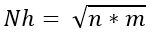

Donde:
- n es la cantidad de inputs
- m es la cantidad de outputs

Por otro lado, la cantidad de neuronas para una red con dos capas ocultas se calcula así:

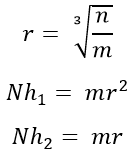

Si se quisiera utilizar este mismo principio para una red con tres capas ocultas, a cantidad de neuronas en cada una de ellas se calcula de esta manera:

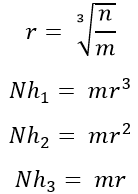

In [ ]:
Nh = pow(INPUTS*OUTPUTS, 1/2)

mlp_masters_1l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_1l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh))
print()

mlp_masters_1l.summary()

In [ ]:
mlp_masters_1l_fit = fit_model(mlp_masters_1l)

In [ ]:
#r = (n/m)^(1/3)
r = pow(INPUTS/OUTPUTS, 1/3)    # = 4.279
                                
Nh1 = OUTPUTS*pow(r,2)          # = 183.179
Nh2 = OUTPUTS*r                 # = 42.799
                            
mlp_masters_2l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh1, activation='sigmoid'),
    Dense(Nh2, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_2l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:')
print('    - 1st Layer:', math.trunc(Nh1))
print('    - 2nd Layer:', math.trunc(Nh2))
print()

mlp_masters_2l.summary()

In [ ]:
mlp_masters_2l_fit = fit_model(mlp_masters_2l)

In [ ]:
#r = (n/m)^(1/3)
r = pow(INPUTS/OUTPUTS, 1/3)    # = 4.279
                                
Nh1 = OUTPUTS*pow(r,3)          # = 783.478
Nh2 = OUTPUTS*pow(r,2)          # = 183.179
Nh3 = OUTPUTS*r                 # = 42.799
                            
mlp_masters_3l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh1, activation='sigmoid'),
    Dense(Nh2, activation='sigmoid'),
    Dense(Nh3, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_3l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:')
print('    - 1st Layer:', math.trunc(Nh1))
print('    - 2nd Layer:', math.trunc(Nh2))
print('    - 3rd Layer:', math.trunc(Nh3))
print()

mlp_masters_3l.summary()

In [ ]:
mlp_masters_3l_fit = fit_model(mlp_masters_3l)

In [ ]:
# Comparison between all three models based on Masters idea
plot_model(model_1=mlp_masters_1l_fit, model_2=mlp_masters_2l_fit, model_3=mlp_masters_3l_fit, 
    title="Masters's proposed MLP models", subtitle_1='1 Hidden Layer MLP', subtitle_2='2 Hidden Layers MLP', subtitle_3='3 Hidden Layers MLP')
plot_cm(mlp_masters_1l, mlp_masters_2l, mlp_masters_3l, 
    title="Masters's proposed MLP models", subtitle_1='1 Hidden Layer MLP', subtitle_2='2 Hidden Layers MLP', subtitle_3='3 Hidden Layers MLP')

## Tamura and Tateishi (1997)
Tamura and Tateishi desarrollaron un método basado en el Criterio de Información de Akaike. La cantidad de neuronas en una red neuronal tres capas es N-1, y en una red neuronal de cuatro capas, es (N/2)+3, donde N es resta entre la cantidad de inputs y outputs.

Tamura and Tateishi developed a method to fix the number of hidden neuron. The number of hidden neurons in three layer neural network is N − 1 and four-layer neural network is N/2 + 3 where N is the input-target relation.

In [ ]:
N = INPUTS-OUTPUTS              # 774
Nh = N-1                        # 773

mlp_tamura_3l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_tamura_3l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh), 'on each of the 3 layers')
print()

mlp_tamura_3l.summary()

In [ ]:
mlp_tamura_3l_fit = fit_model(mlp_tamura_3l)

In [ ]:
N = INPUTS-OUTPUTS              # 774
Nh = (N/2)+3                    # 390

mlp_tamura_4l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_tamura_4l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh), 'on each of the 4 layers')
print()

mlp_tamura_4l.summary()

In [ ]:
mlp_tamura_4l_fit = fit_model(mlp_tamura_4l)

In [ ]:
# Comparison between two models based on Tamura and Tateishi's model
plot_model(model_1=mlp_tamura_3l_fit, model_2=mlp_tamura_4l_fit, 
    title="Tamura and Tateishi's proposed MLP models", subtitle_1='3 Hidden Layers MLP', subtitle_2='4 Hidden Layers MLP')
plot_cm(model_1=mlp_tamura_3l, model_2=mlp_tamura_4l, 
    title="Tamura and Tateishi's proposed MLP models", subtitle_1='3 Hidden Layers MLP', subtitle_2='4 Hidden Layers MLP')

# Grid Search MLP

param_grid = {
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [x for x in itertools.product((10,50,100),repeat=3)],
    'activation': ["logistic", "relu", "tanh"]
}  
base_estimator = MLP

In [ ]:
# Reshape de X_train a 2D para GridSearchCV
feature_vector_length = 784
num_classes = 10

X_trainR = X_train.reshape(X_train.shape[0], feature_vector_length)
X_testR = X_test.reshape(X_test.shape[0], feature_vector_length)

import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 

# defining parameter range 
param_grid = {
    'hidden_layer_sizes': [(10,10),(10,10,10)],
    'batch_size': [128, 256, 512],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': 10.0 ** -np.arange(1, 5),
    
    'max_iter': [30],
    'solver': ['adam'],
}  

'''
grid2 = GridSearchCV(MLPClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, cv=3)

# fitting the model for grid search 
grid2.fit(X_trainR, Y_train) 
 
# print best parameter after tuning 
print(grid2.best_params_) 
grid_predictions = grid2.predict(X_testR) 
   
# print classification report 
print(classification_report(Y_test, grid_predictions)) 
'''

In [ ]:
model = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    
    Convolution2D(input_shape=(28, 28, 1), filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x1, y salida de 26x26x8
    Dropout(0.2),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 58x58x8
    Dropout(0.2),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 14x14x8
    
    Flatten(),
    # salida de 1568
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(LABELS), activation='softmax'),
    # salida de 10
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

model.summary()

In [ ]:
history = model.fit(
    X_train,
    Y_train, 
    epochs=5,
    batch_size=500,
    validation_data=(X_test, Y_test),
)

# Prunning

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

# Data Augmentation

In [ ]:
train, test = fashion_mnist.load_data()
X_train, Y_train = train 
X_test, Y_test = test

In [ ]:
train_alterado = ImageDataGenerator(
    rescale=1/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    vertical_flip=False,
    
)
train_DA = train_alterado.flow(X_train.reshape(60000,28,28,1),Y_train,batch_size=60000)

X_train_DA, Y_train_DA = train_DA.next()
X_train_DA.shape

In [ ]:
sample_images(train_DA)

In [ ]:
X_train=X_train.reshape(60000,28,28,1)

In [ ]:
#realizamos la concatenación de los datasets original y el modificado
X_train_DA = np.concatenate((X_train_DA, X_train))
Y_train_DA = np.concatenate((Y_train_DA, Y_train))
print(X_train.shape)
print(X_train_DA.shape)